# Generate Hamiltonian data

In [1]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp, AnsatzOp, ObservableOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))

molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [2]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.UCC_q, ref_state=hf_array) #molecule.T_q
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [3]:
n_qubits = 3
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'IIX', 'ZZX', 'IXI', 'ZXZ', 'IXX', 'IYY', 'XII', 'XZZ', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[-12.488598  +0.j,  -0.85829425+0.j,  -0.85829425+0.j,   0.02304318+0.j,
  -0.85829425+0.j,   0.02304318+0.j,   0.02304318+0.j,   0.64247074+0.j,
  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,  -0.04340449+0.j,  -0.04340449+0.j,
   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j,   0.01212469+0.j]), coeff=1.0)

In [4]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)

print(gs_psi)
print()
print(f'Contextual subspace ground state error = {gs_energy - molecule.fci_energy}')

-0.9461446877+0.0000000000j |000> +
-0.1869137323+0.0000000000j |001> +
-0.1869137323+0.0000000000j |010> +
-0.1869137323+0.0000000000j |100>

Contextual subspace ground state error = 0.0003265059338524168


In [12]:
anz_cs

-0.098 IIY +
-0.098 ZZY +
-0.096 IYI +
-0.096 ZYZ +
-0.094 YII +
-0.094 YZZ

In [5]:
print(anz_cs.coeff_vec)
obs = ObservableOp(ham_cs.symp_matrix, ham_cs.coeff_vec)
vqe_result = obs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs
)

opt_params = vqe_result[0]['x']
print(anz_cs.coeff_vec)
vqe_result[0]['fun'] - molecule.fci_energy

[-0.09847679 -0.09847679 -0.09847679 -0.09847679 -0.09847679 -0.09847679]
[-0.09771918 -0.09771918 -0.09575265 -0.09575265 -0.09389815 -0.09389815]


0.0003265823239786414

In [6]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

# Submit VQE Runtime program to IBMQ

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
# only run the following the first time you connect to the service
#token = "a26e0769ddee03aa5f95f38edb1266efa1190059c7d60c1784ca3ec1e4c3c84bc375947c2bc8d2bc4ab39e32ea64ae6376b1f631936a416c7b8bdaed8b94a9cb"
#QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [8]:
for name in service.backends():
    print(f'Backend name: {name.name: <29} | '+
          f'Number of qubits: {name.num_qubits: <4} | '+
          f'Number of jobs queued: {name.status().pending_jobs}'
    )

Backend name: ibmq_qasm_simulator           | Number of qubits: 32   | Number of jobs queued: 3
Backend name: ibmq_armonk                   | Number of qubits: 1    | Number of jobs queued: 2
Backend name: ibmq_lima                     | Number of qubits: 5    | Number of jobs queued: 33
Backend name: ibmq_belem                    | Number of qubits: 5    | Number of jobs queued: 32
Backend name: ibmq_quito                    | Number of qubits: 5    | Number of jobs queued: 136
Backend name: simulator_statevector         | Number of qubits: 32   | Number of jobs queued: 1
Backend name: simulator_mps                 | Number of qubits: 100  | Number of jobs queued: 1
Backend name: simulator_extended_stabilizer | Number of qubits: 63   | Number of jobs queued: 1
Backend name: simulator_stabilizer          | Number of qubits: 5000 | Number of jobs queued: 1
Backend name: ibmq_manila                   | Number of qubits: 5    | Number of jobs queued: 236
Backend name: ibm_nairobi         

Define the ansatz:

In [55]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
#excitation_circuit_A = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=1, insert_barriers=True, parameter_prefix='A').decompose()
#excitation_circuit_B = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=1, insert_barriers=True, parameter_prefix='B').decompose()
#excitation_circuit_B.data = excitation_circuit_B.data[:-2*n_qubits]
#excitation_circuit = excitation_circuit_A.compose(excitation_circuit_B.reverse_ops())

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
#ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.draw()

░ ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌─────┐┌───┐          »
q_0: ─░─┤ Sdg ├┤ H ├┤ Rz(-2*P[0]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■───────»
      ░ └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘┌─┴─┐     »
q_1: ─░───────────────────────────────────────░─────────────┤ X ├──■──»
      ░                                       ░             └───┘┌─┴─┐»
q_2: ─░───────────────────────────────────────░──────────────────┤ X ├»
      ░                                       ░                  └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐└───┘└───┘ ░ ┌─────┐┌───┐┌─────────────┐┌───┐»
«q_1: ─────────────────■──┤ X ├───────────░─┤ Sdg ├┤ H ├┤ Rz(-2*P[2]) ├┤ H ├»
«     ┌─────────────┐┌─┴─┐└───┘           ░ └─────┘└───┘└─────────────┘└───┘»
«q_2: ┤ Rz(-2*P[1]) ├┤ X ├────────────────░─────────────────────────────────»
«     └─────────────┘└───┘                ░                                 »
«           ░                                                           ░ »
«q_0: ──────░───────────────■─────────────────────────────■─────────────░─»
«     ┌───┐ ░ ┌─────┐┌───┐┌─┴─┐                         ┌─┴─┐┌───┐┌───┐ ░ »
«q_1: ┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├──■───────────────────■──┤ X ├┤ H ├┤ S ├─░─»
«     └───┘ ░ └─────┘└───┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘└───┘└───┘ ░ »
«q_2: ──────░──────────────────┤ X ├┤ Rz(-2*P[3]) ├┤ X ├────────────────░─»
«           ░                  └───┘└─────────────┘└───┘                ░ »
«                                           ░                                 »
«q_0: ──────────────────────────────────────░────■────────────────────────────»
«                                           ░  ┌─┴─┐                          »
«q_1: ──────────────────────────────────────░──┤ X ├────────■─────────────────»
«     ┌─────┐┌───┐┌─────────────┐┌───┐┌───┐ ░ ┌┴───┴┐┌───┐┌─┴─┐┌─────────────┐»
«q_2: ┤ Sdg ├┤ H ├┤ Rz(-2*P[4]) ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ Rz(-2*P[5]) ├»
«     └─────┘└───┘└─────────────┘└───┘└───┘ ░ └─────┘└───┘└───┘└─────────────┘»
«                     ░ 
«q_0: ───────■────────░─
«          ┌─┴─┐      ░ 
«q_1: ──■──┤ X ├──────░─
«     ┌─┴─┐├───┤┌───┐ ░ 
«q_2: ┤ X ├┤ H ├┤ S ├─░─
«     └───┘└───┘└───┘ ░

In [57]:
from symmer.simulation import ADAPT_CS_VQE

In [75]:
adapt = ADAPT_CS_VQE(ansatz_pool=anz_cs, ref_state=ref_cs, operator=ham_tap)
adapt.ADAPT_VQE([0])

TypeError: reduce() of empty sequence with no initial value

In [306]:
from qiskit.opflow import StateFn
psi = StateFn(ansatz.bind_parameters(anz_cs.coeff_vec)).to_spmatrix()

(psi @ ham_cs.to_sparse_matrix @ psi.H)[0,0] - molecule.fci_energy

(0.00036456488604841297+4.5606021083089745e-31j)

Specify the runtime inputs:

In [308]:
backend_name = 'ibm_oslo' #'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": anz_cs.coeff_vec,
    "optimizer": 'COBYLA',
    "n_groups":5,
    "opt_setting": {"maxiter":10},#, "gtol": 1e-5},
    "n_shots": 2**16, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":1,
    "mitigate_errors": True
    
}

Submit the job:

In [309]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

print(job.job_id)

In [310]:
service.backend(backend_name).status()

'casukh3e68ooh09rsu30'

In [312]:
job_id_1 = 'casp1ure68ooh09r3rm0'
job_id_2 = 'casqob1ihlmte2bsm0r0'
job_id_3 = 'casqvabe68ooh09rcgcg'
job_id_4 = 'casstaje68ooh09rlmq0'
job_id_5 = 'casukh3e68ooh09rsu30'

In [322]:
job = service.job(job_id_5)

KeyboardInterrupt: 

In [ ]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
job.error_message()

In [ ]:
print(molecule.hf_energy, molecule.mp2_energy, molecule.ccsd_energy, molecule.fci_energy)
job.interim_results()

Retrieve the data and plot:

In [287]:
vqe_result, interim_values = job.result()

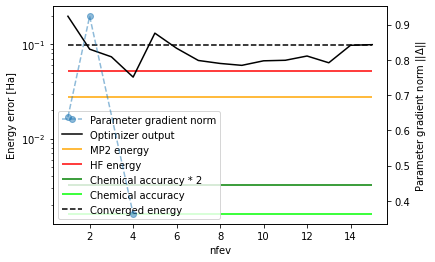

In [288]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()